In [1]:
import pandas as pd
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

### Read data

In [2]:
df_fertilizers_raw = pd.read_csv('data/Fertilizers_FAOSTAT_data_en_12-3-2022.csv')
df_emissions_raw = pd.read_csv('data/Emissions_FAOSTAT_data_en_12-3-2022.csv')
df_yield_raw = pd.read_csv('data/FAOSTAT_data_en_12-3-2022.csv')

In [3]:
df_precip_1990_raw = pd.read_csv('data/pr_climatology_annual-monthly_cru_1961-1990_IND.csv', skiprows=1, index_col=0)
df_precip_2020_raw = pd.read_csv('data/pr_climatology_annual-monthly_cru_1991-2020_IND.csv', skiprows=1, index_col=0)
df_maxtemp_1990_raw = pd.read_csv('data/tasmax_climatology_annual-monthly_cru_1961-1990_IND.csv', skiprows=1, index_col=0)
df_maxtemp_2020_raw = pd.read_csv('data/tasmax_climatology_annual-monthly_cru_1991-2020_IND.csv', skiprows=1, index_col=0)
df_avgtemp_1990_raw = pd.read_csv('data/tas_climatology_annual-monthly_cru_1961-1990_IND.csv', skiprows=1, index_col=0)
df_avgtemp_2020_raw = pd.read_csv('data/tas_climatology_annual-monthly_cru_1991-2020_IND.csv', skiprows=1, index_col=0)
df_mintemp_1990_raw = pd.read_csv('data/tasmin_climatology_annual-monthly_cru_1961-1990_IND.csv', skiprows=1, index_col=0)
df_mintemp_2020_raw = pd.read_csv('data/tasmin_climatology_annual-monthly_cru_1991-2020_IND.csv', skiprows=1, index_col=0)

In [4]:
df_precip_annual_raw = pd.read_csv('data/pr_timeseries_annual_cru_1901-2021_IND.csv', skiprows=1, index_col=0)
df_maxtemp_annual_raw = pd.read_csv('data/tasmax_timeseries_annual_cru_1901-2021_IND.csv', skiprows=1, index_col=0)
df_avgtemp_annual_raw = pd.read_csv('data/tas_timeseries_annual_cru_1901-2021_IND.csv', skiprows=1, index_col=0)
df_mintemp_annual_raw = pd.read_csv('data/tasmin_timeseries_annual_cru_1901-2021_IND.csv', skiprows=1, index_col=0)

### Climatology

In [5]:
index = df_precip_annual_raw.iloc[-61:-1].index
df_climatology = pd.DataFrame(index=index, columns=['precipitation', 'min_temp', 'avg_temp', 'max_temp'])
state_mask = ['Uttar Pradesh', 'Bihar', 'West Bengal']
df_climatology['precipitation'] = df_precip_annual_raw.iloc[-61:-1][state_mask].apply(lambda x: x.mean(), axis=1)
df_climatology['min_temp'] = df_mintemp_annual_raw.iloc[-61:-1][state_mask].apply(lambda x: x.mean(), axis=1)
df_climatology['avg_temp'] = df_avgtemp_annual_raw.iloc[-61:-1][state_mask].apply(lambda x: x.mean(), axis=1)
df_climatology['max_temp'] = df_maxtemp_annual_raw.iloc[-61:-1][state_mask].apply(lambda x: x.mean(), axis=1)

In [6]:
state_mask = ['Uttar Pradesh', 'Bihar', 'West Bengal']
df_precip_1990 = df_precip_1990_raw.loc[state_mask, :].mean(axis=0).to_frame(name='1961-1990')
df_precip_2020 = df_precip_2020_raw.loc[state_mask, :].mean(axis=0).to_frame(name='1991-2020')
df_precip = pd.concat([df_precip_1990, df_precip_2020], axis=1)

df_maxtemp_1990 = df_maxtemp_1990_raw.loc[state_mask, :].mean(axis=0).to_frame(name='1961-1990')
df_maxtemp_2020 = df_maxtemp_2020_raw.loc[state_mask, :].mean(axis=0).to_frame(name='1991-2020')
df_maxtemp = pd.concat([df_maxtemp_1990, df_maxtemp_2020], axis=1)

df_avgtemp_1990 = df_avgtemp_1990_raw.loc[state_mask, :].mean(axis=0).to_frame(name='1961-1990')
df_avgtemp_2020 = df_avgtemp_2020_raw.loc[state_mask, :].mean(axis=0).to_frame(name='1991-2020')
df_avgtemp = pd.concat([df_avgtemp_1990, df_avgtemp_2020], axis=1)

df_mintemp_1990 = df_mintemp_1990_raw.loc[state_mask, :].mean(axis=0).to_frame(name='1961-1990')
df_mintemp_2020 = df_mintemp_2020_raw.loc[state_mask, :].mean(axis=0).to_frame(name='1991-2020')
df_mintemp = pd.concat([df_mintemp_1990, df_mintemp_2020], axis=1)


### Fertilizer 

In [7]:
nitrogen_mask = df_fertilizers_raw['Item'] == 'Nutrient nitrogen N (total)'
phosphate_mask = df_fertilizers_raw['Item'] == 'Nutrient phosphate P2O5 (total)'
potash_mask = df_fertilizers_raw['Item'] == 'Nutrient potash K2O (total)'
df_fertilizers_nitrogen = df_fertilizers_raw[nitrogen_mask].set_index('Year')
df_fertilizers_phosphate = df_fertilizers_raw[phosphate_mask].set_index('Year')
df_fertilizers_potash = df_fertilizers_raw[potash_mask].set_index('Year')

### Emission 

In [8]:
co2_mask = df_emissions_raw['Element'] == 'Emissions (CO2)'
df_emissions_co2 = df_emissions_raw[co2_mask].set_index('Year')
df_emissions_co2 = df_emissions_co2.groupby('Year')[['Value']].mean()

### Production

In [9]:
df_yield_raw['Element'].unique()

array(['Area harvested', 'Yield', 'Production'], dtype=object)

In [10]:
production_mask = df_yield_raw['Element'] == 'Production'
df_production = df_yield_raw[production_mask].set_index('Year')

In [11]:
df_production.head()

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code (CPC),Item,Year Code,Unit,Value,Flag,Flag Description
Year,,,,,,,,,,,,,
1961,QCL,Crops and livestock products,356,India,5510,Production,1510,Potatoes,1961,tonnes,2719000,A,Official figure
1962,QCL,Crops and livestock products,356,India,5510,Production,1510,Potatoes,1962,tonnes,2447000,A,Official figure
1963,QCL,Crops and livestock products,356,India,5510,Production,1510,Potatoes,1963,tonnes,3365000,A,Official figure
1964,QCL,Crops and livestock products,356,India,5510,Production,1510,Potatoes,1964,tonnes,2593000,A,Official figure
1965,QCL,Crops and livestock products,356,India,5510,Production,1510,Potatoes,1965,tonnes,3605000,A,Official figure


/Users/spartan/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


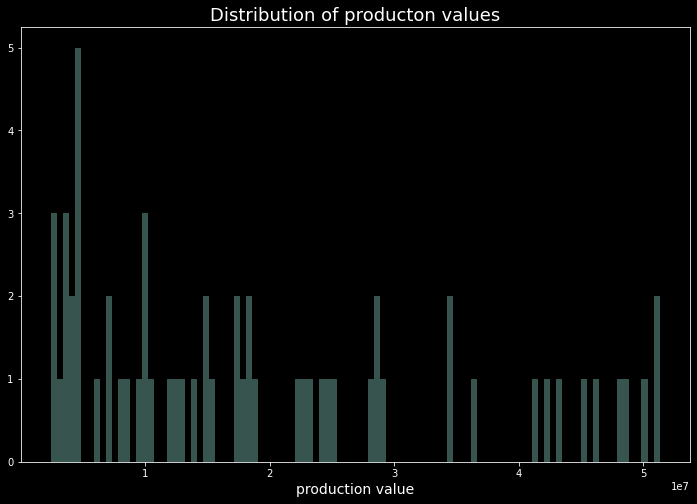

In [12]:
plt.figure(figsize=(12,8))
sns.distplot(df_production.Value, bins=100, kde=False)
plt.xlabel('production value', fontsize=14)
plt.title('Distribution of producton values', fontsize = 18)
plt.show()

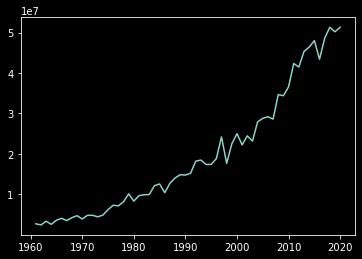

In [13]:
plt.plot(df_production.index, df_production['Value'])

### Correlation between target and feature variables

##### Production and fertilizer

In [14]:
df_prod_fertilizer = pd.DataFrame(index=df_production.index, columns=['production', 'nitrogen', 'phosphate', 'potash'])
mm_scaler = MinMaxScaler()
df_prod_fertilizer['production']=mm_scaler.fit_transform(df_production['Value'].values.reshape(-1, 1))
df_prod_fertilizer['nitrogen']=mm_scaler.fit_transform(df_fertilizers_nitrogen['Value'].values.reshape(-1, 1))
df_prod_fertilizer['phosphate']=mm_scaler.fit_transform(df_fertilizers_phosphate['Value'].values.reshape(-1, 1))
df_prod_fertilizer['potash']=mm_scaler.fit_transform(df_fertilizers_potash['Value'].values.reshape(-1, 1))

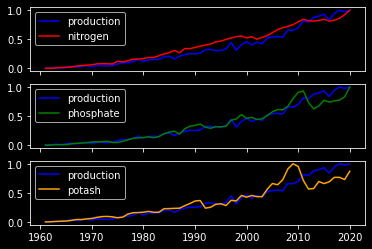

In [15]:
x=df_prod_fertilizer.index
fig, ax = plt.subplots(nrows=3, sharex=True)

ax[0].plot(x, df_prod_fertilizer['production'], color='blue', label='production')
ax[0].plot(x, df_prod_fertilizer['nitrogen'], color='red', label='nitrogen')
ax[0].legend()

ax[1].plot(x, df_prod_fertilizer['production'], color='blue', label='production')
ax[1].plot(x, df_prod_fertilizer['phosphate'], color='green', label='phosphate')
ax[1].legend()

ax[2].plot(x, df_prod_fertilizer['production'], color='blue', label='production')
ax[2].plot(x, df_prod_fertilizer['potash'], color='orange', label='potash')
ax[2].legend()

In [16]:
df_prod_fertilizer.corr()

,production,nitrogen,phosphate,potash
production,1.000000,0.973624,0.961905,0.922592
nitrogen,0.973624,1.000000,0.983929,0.949675
phosphate,0.961905,0.983929,1.000000,0.969988
potash,0.922592,0.949675,0.969988,1.000000


There appears a very high correlation of each fertilizer with the production of potatoes

##### Production and emission co2

In [17]:
df_prod_emission = pd.DataFrame(index=df_production.tail(31).index, columns=['production', 'co2'])
mm_scaler = MinMaxScaler()
df_prod_emission['production']=mm_scaler.fit_transform(df_production['Value'].tail(31).values.reshape(-1, 1))
df_prod_emission['co2']=mm_scaler.fit_transform(df_emissions_co2['Value'].values.reshape(-1, 1))

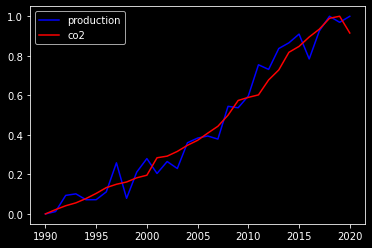

In [18]:
x=df_prod_emission.index
fig, ax = plt.subplots()

ax.plot(x, df_prod_emission['production'], color='blue', label='production')
ax.plot(x, df_prod_emission['co2'], color='red', label='co2')
ax.legend()

In [19]:
df_prod_emission.corr()

,production,co2
production,1.000000,0.982883
co2,0.982883,1.000000


##### Production and climate

In [20]:
df_prod_climate = pd.DataFrame(index=df_climatology.index, columns=['production', 'precipitation', 'min_temp', 'avg_temp', 'max_temp'])
mm_scaler = MinMaxScaler()
df_prod_climate['production']=mm_scaler.fit_transform(df_production['Value'].values.reshape(-1, 1))
df_prod_climate['precipitation']=mm_scaler.fit_transform(df_climatology['precipitation'].values.reshape(-1, 1))
df_prod_climate['min_temp']=mm_scaler.fit_transform(df_climatology['min_temp'].values.reshape(-1, 1))
df_prod_climate['avg_temp']=mm_scaler.fit_transform(df_climatology['avg_temp'].values.reshape(-1, 1))
df_prod_climate['max_temp']=mm_scaler.fit_transform(df_climatology['max_temp'].values.reshape(-1, 1))

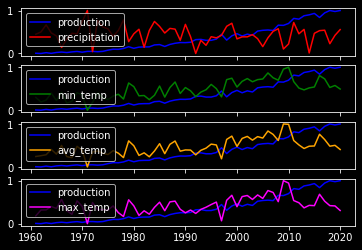

In [21]:
x=df_prod_climate.index
fig, ax = plt.subplots(nrows=4, sharex=True)

ax[0].plot(x, df_prod_climate['production'], color='blue', label='production')
ax[0].plot(x, df_prod_climate['precipitation'], color='red', label='precipitation')
ax[0].legend()

ax[1].plot(x, df_prod_climate['production'], color='blue', label='production')
ax[1].plot(x, df_prod_climate['min_temp'], color='green', label='min_temp')
ax[1].legend()

ax[2].plot(x, df_prod_climate['production'], color='blue', label='production')
ax[2].plot(x, df_prod_climate['avg_temp'], color='orange', label='avg_temp')
ax[2].legend()

ax[3].plot(x, df_prod_climate['production'], color='blue', label='production')
ax[3].plot(x, df_prod_climate['max_temp'], color='magenta', label='max_temp')
ax[3].legend()

In [22]:
df_prod_climate.corr()

,production,precipitation,min_temp,avg_temp,max_temp
production,1.000000,-0.179659,0.626000,0.538645,0.403800
precipitation,-0.179659,1.000000,-0.195626,-0.259441,-0.309338
min_temp,0.626000,-0.195626,1.000000,0.967825,0.861353
avg_temp,0.538645,-0.259441,0.967825,1.000000,0.961432
max_temp,0.403800,-0.309338,0.861353,0.961432,1.000000


Two time series which share the same trend will show high correlation. However, Pearson’s correlation is a statistic, measuring linear association of variables. Values over time could have an internal structure. That could include trends, seasonality, or auto-correlation. Therefore, correlation is a good estimate only of the trend behaviour of time series 

##### correlation of each lagged observation to determine if statistically significant.

In [23]:
df_prod_temp = df_production[['Value']]
df_prod_temp.head()

,Value
Year,
1961,2719000
1962,2447000
1963,3365000
1964,2593000
1965,3605000


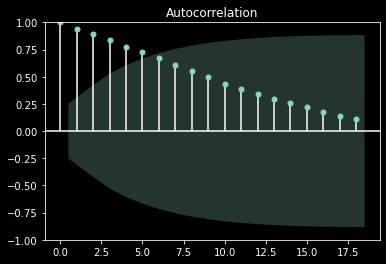

In [24]:
plot_acf(df_prod_temp);

The correlation of 1 for the lag value of 0 indicates 100% positive correlation of an observation with itself. The autocorrelation function shows a slow decay, which means that the future values have a very high correlation with its past values.

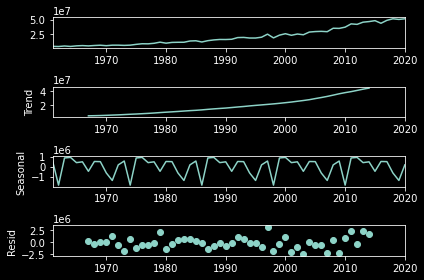

In [25]:
seasonal_decompose(df_prod_temp, model='additive', period=12).plot();

#### RIFE

In [26]:
df_prod_climate_emission_fertilizer = df_prod_climate.join(df_prod_emission['co2']).join(df_prod_fertilizer[['nitrogen', 'phosphate', 'potash']])

In [27]:
df_rife = df_prod_climate_emission_fertilizer.dropna()
df_rife.head()

,production,precipitation,min_temp,avg_temp,max_temp,co2,nitrogen,phosphate,potash
1990,0.252211,0.677721,0.527363,0.395310,0.252427,0.000000,0.359404,0.340397,0.359191
1991,0.261110,0.389155,0.451078,0.391960,0.317152,0.021800,0.382934,0.362157,0.367654
1992,0.322289,0.000000,0.315091,0.281407,0.237864,0.041301,0.402110,0.309366,0.236483
1993,0.328101,0.306071,0.421227,0.386935,0.331715,0.055975,0.418690,0.289499,0.250588
1994,0.305863,0.190381,0.475954,0.437186,0.381877,0.077687,0.454446,0.318448,0.302304


In [28]:
array = df_rife.values
X = array[:,1:-1]
y = array[:,0]

In [29]:
rfe = RFE(RandomForestRegressor(n_estimators=500, random_state=1), n_features_to_select=4)
fit = rfe.fit(X, y)

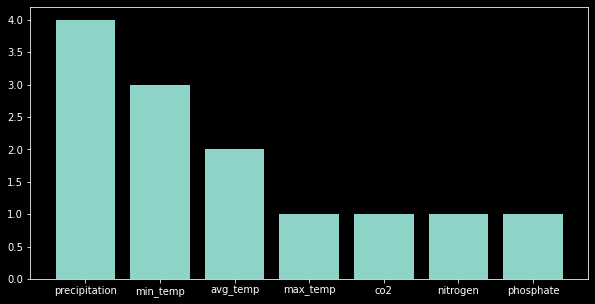

In [30]:
plt.figure(figsize=(10,5))
names = df_rife.columns.values[1:-1]
ticks = [i for i in range(len(names))]
plt.bar(ticks, fit.ranking_)
plt.xticks(ticks, names)
plt.rcParams['figure.figsize'] = [10, 10]
plt.show()

As seen from above plot, RFE suggests the top features as precipitation, min temp, avg temp and max temp as the important features wrt to produciton values and hence we can use these to predict production going forward.